In [1]:
import sys
sys.path.append('C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import logging
import cProfile
from tqdm.notebook import tqdm

import utils
import config
import strat_test
importlib.reload(utils)
importlib.reload(config)
importlib.reload(strat_test)

<module 'strat_test' from 'C:\\Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest\\strat_test\\__init__.py'>

In [2]:
# config
cfg = config.config
blacklist = cfg['universe']['black']
quote_dir = cfg['folder']['quote']

factor_dir = 'C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A04_指数编制/quote/QUOTE_INDUSTRY/assembler'

end_date = '2025-12-31'

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

plt.rcParams['figure.figsize'] = (12, 3)
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.grid'] = True
%config InlineBackend.figure_format = 'retina'

## Load data

In [3]:
# # futures data from quote basic
# opens = pd.DataFrame()

# data_name = "open777"

# for v in blacklist:
#     dir_path = os.path.join(quote_dir, "QUOTE_BASIC", "assembler", data_name, f"{v}.csv")
#     df = pd.read_csv(dir_path, index_col=0, parse_dates=True)
#     df = df.loc[:end_date]
#     opens[v] = df[data_name]
#     logger.info(f"Read {v} with {len(df)} rows")

# # add black index
# index_dir = os.path.join(quote_dir, "INDEX/black_open_index_qb.csv")
# black_index = pd.read_csv(index_dir, index_col=0, parse_dates=True)
# opens["black"] = black_index

prices = pd.read_csv("C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result/rb_price/历史净值.csv", index_col=0, parse_dates=True, header=None)
prices = prices.loc[:end_date]
prices.columns = ["rb"]

## I_S006273513
100大中城市:成交土地规划建筑面积:当周值
似乎用不了？

Text(0.5, 1.0, 'I_S006273513')

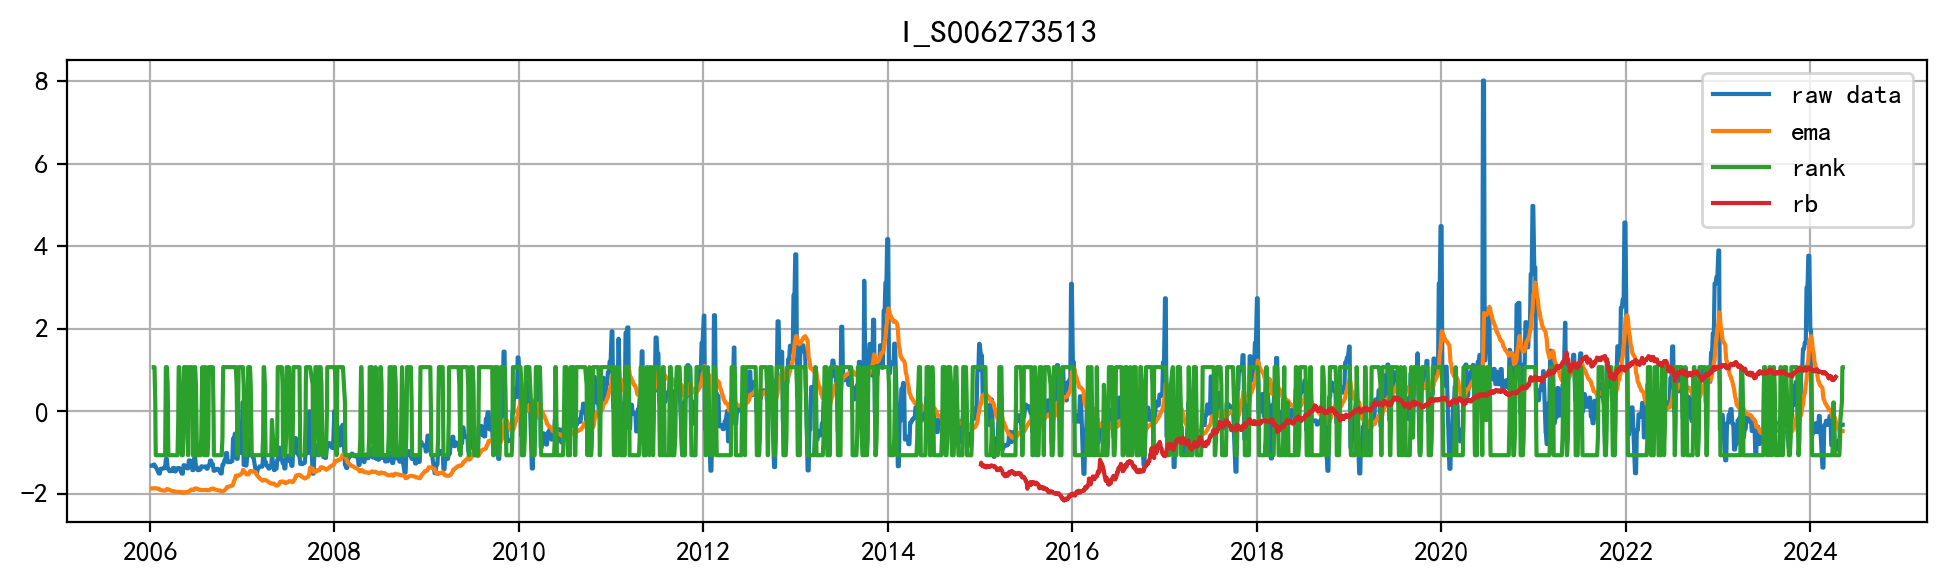

In [4]:
name = "I_S006273513"
I_S006273513 = pd.read_csv(f'{factor_dir}/real_estate.csv',index_col=0, parse_dates=True)[name]
I_S006273513 = I_S006273513.loc[:end_date]
plt.plot(utils.scale(I_S006273513), label='raw data')
I_S006273513 = utils.ema(I_S006273513, 1/35)
plt.plot(utils.scale(I_S006273513), label='ema')
# I_S006273513 = I_S006273513.diff()
# plt.plot(utils.scale(I_S006273513), label='diff')
I_S006273513 = utils.ts_rank(I_S006273513, 6, "dynamic") - 0.5
plt.plot(utils.scale(I_S006273513, how='divstd'), label='rank')
plt.plot(utils.scale(prices['rb'], how='standard'), label='rb')
plt.legend()
plt.title(name)

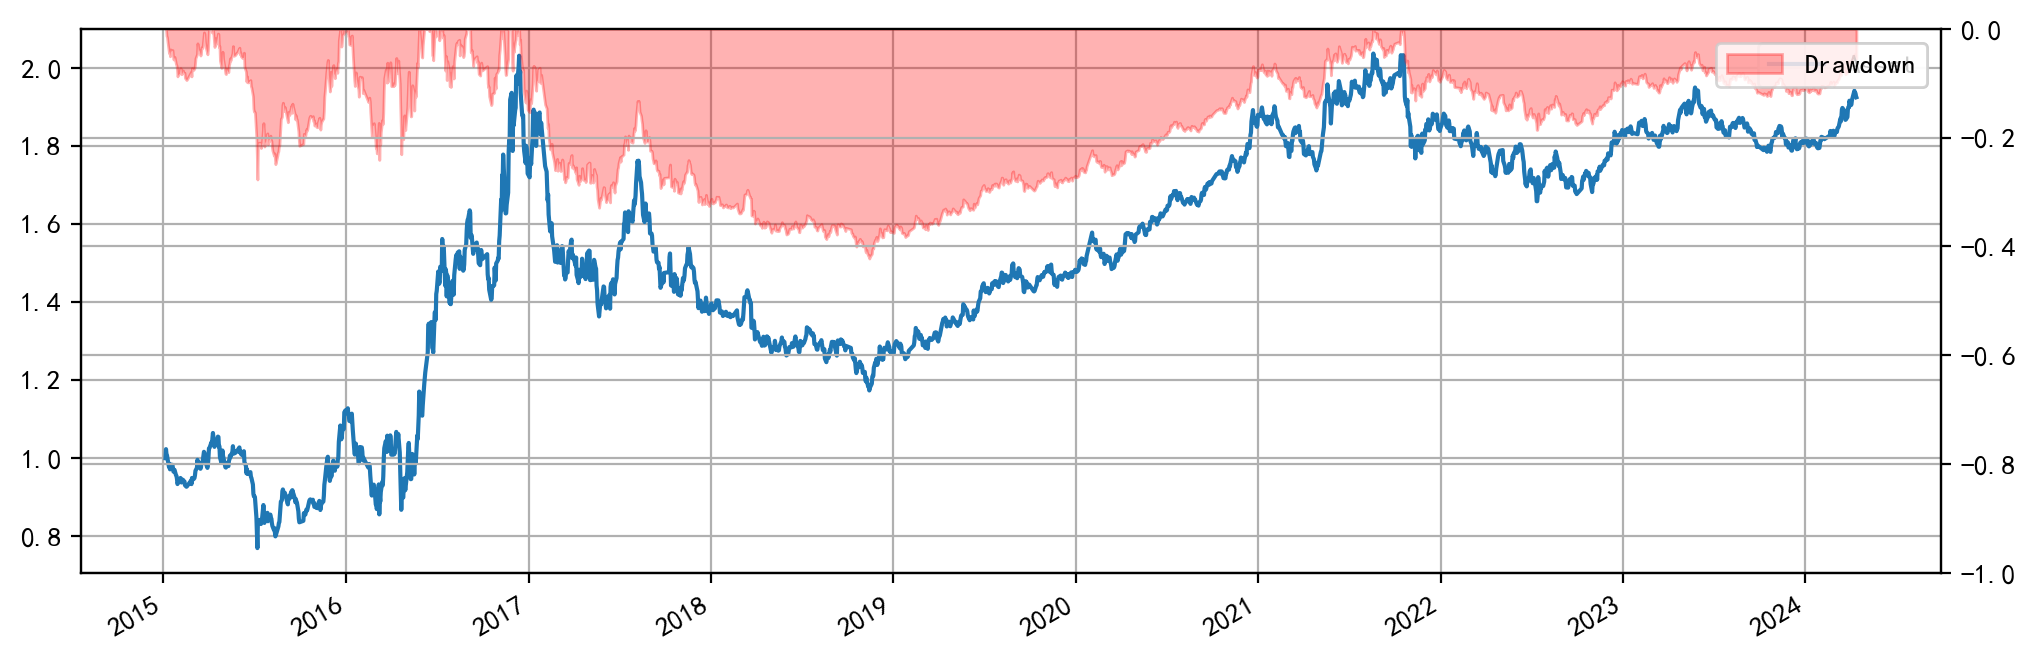

In [5]:
posi = I_S006273513 / I_S006273513.abs()
posi = posi.replace(np.nan, 0)
price, posi = prices['rb'].align(posi, join='inner')
price.name = posi.name = 'rb'
nwm = strat_test.NetWorthMaker(price, posi)
nwm.plot()

In [6]:
def test_params(name, end_date, ema_alpha=1/20, ts_rank_w=75):
    factor = pd.read_csv(f'{factor_dir}/real_estate.csv',index_col=0, parse_dates=True)[name]
    factor = factor.loc[:pd.to_datetime(end_date)]
    factor = utils.ema(factor, ema_alpha)
    # factor = factor.diff()
    factor = utils.ts_rank(factor, ts_rank_w, "dynamic") - 0.5
    posi = factor / factor.abs()
    posi = posi.replace(np.nan, 0)
    price, posi = prices['rb'].align(posi, join='inner')
    price.name = posi.name = 'rb'
    nwm = strat_test.NetWorthMaker(price, posi)
    return nwm, posi

In [211]:
alphas = range(5, 101, 5)
ws = range(2, 20)
rets = pd.DataFrame(index=alphas, columns=ws)

for alpha in tqdm(alphas):
    for w in ws:
        nwm, _ = test_params(name, end_date, ema_alpha=1/alpha, ts_rank_w=w)
        rets.loc[alpha, w] = nwm.get_total().loc['calmar']

  0%|          | 0/20 [00:00<?, ?it/s]

In [212]:
rets.apply(pd.to_numeric).style.background_gradient(axis=None).format("{:.2f}")

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,-0.01,-0.01,-0.01,0.05,0.12,0.15,0.13,0.23,0.33,0.45,0.60,0.44,0.34,0.30,0.22,0.14,0.04,-0.01
10,-0.07,-0.03,0.01,0.08,0.17,0.17,0.16,0.17,0.13,0.05,-0.04,-0.02,-0.01,-0.07,-0.10,-0.10,-0.10,-0.10
15,-0.05,-0.01,0.03,0.12,0.21,0.14,0.06,0.13,0.19,0.15,0.04,-0.03,-0.07,-0.10,-0.11,-0.10,-0.08,-0.08
20,-0.09,-0.06,0.00,0.02,0.02,0.06,0.07,0.10,0.07,0.15,0.24,0.05,-0.04,-0.07,-0.06,-0.07,-0.08,-0.06
25,0.16,0.32,0.49,0.51,0.48,0.35,0.27,0.26,0.24,0.24,0.21,0.03,-0.06,-0.07,-0.04,-0.07,-0.08,-0.07
30,0.32,0.32,0.29,0.39,0.44,0.44,0.40,0.44,0.41,0.15,0.01,-0.01,-0.04,-0.06,-0.08,-0.05,-0.03,-0.03
35,0.51,0.55,0.58,0.61,0.61,0.57,0.51,0.66,0.78,0.34,0.09,0.04,0.00,-0.01,-0.03,0.00,0.03,0.05
40,0.33,0.37,0.40,0.35,0.30,0.41,0.52,0.37,0.23,0.09,-0.05,-0.07,-0.09,-0.08,-0.08,-0.07,-0.06,-0.06
45,0.35,0.40,0.45,0.39,0.33,0.44,0.54,0.37,0.19,0.08,-0.05,-0.07,-0.09,-0.09,-0.09,-0.08,-0.06,-0.06
50,0.15,0.22,0.30,0.27,0.23,0.22,0.18,0.12,0.05,-0.01,-0.06,-0.07,-0.08,-0.09,-0.10,-0.09,-0.06,-0.07


<Axes: >

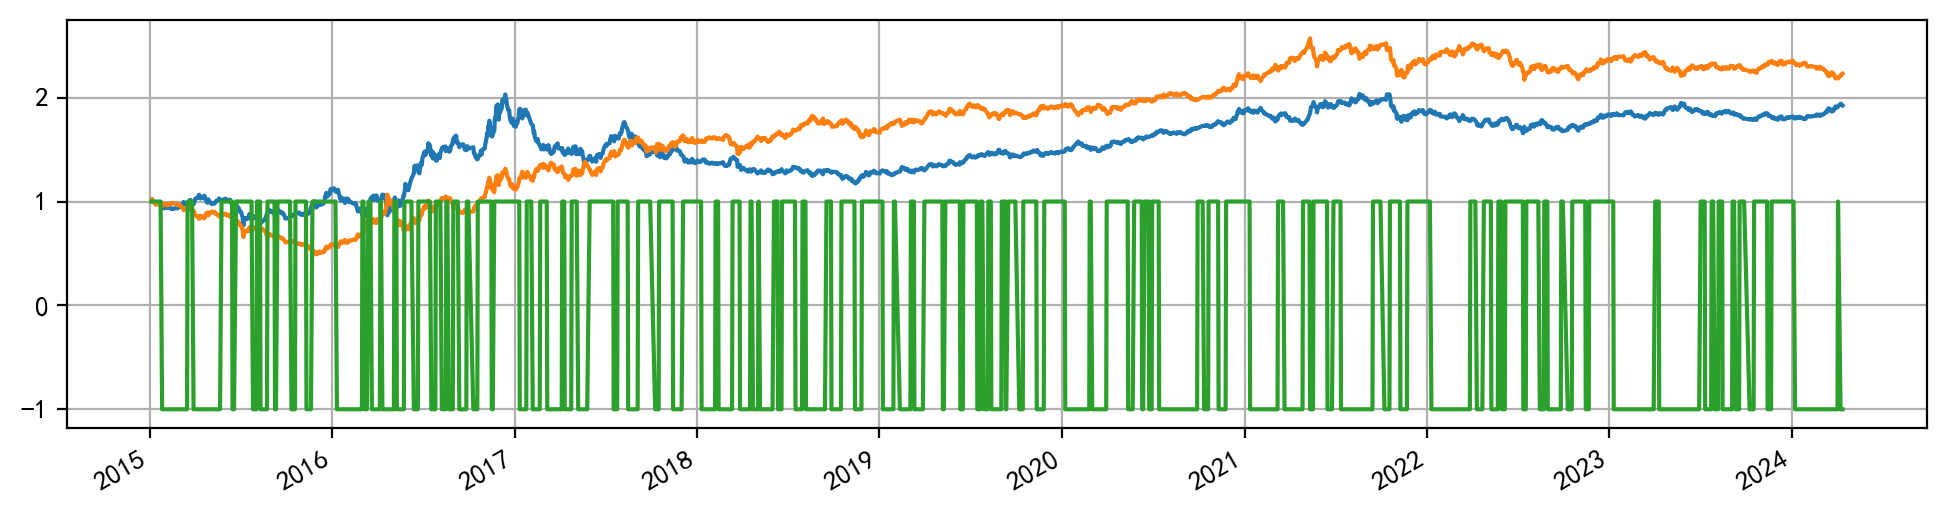

In [7]:
nwm, posi_1 = test_params(name, end_date, ema_alpha=1/35, ts_rank_w=6)
plt.plot(nwm.get_networth(), label='networth')
plt.plot(utils.scale(prices['rb'], "1stvalue"))
posi_1.plot()

## I_S002916784
房屋新开工面积:累计同比

Text(0.5, 1.0, 'I_S002916784')

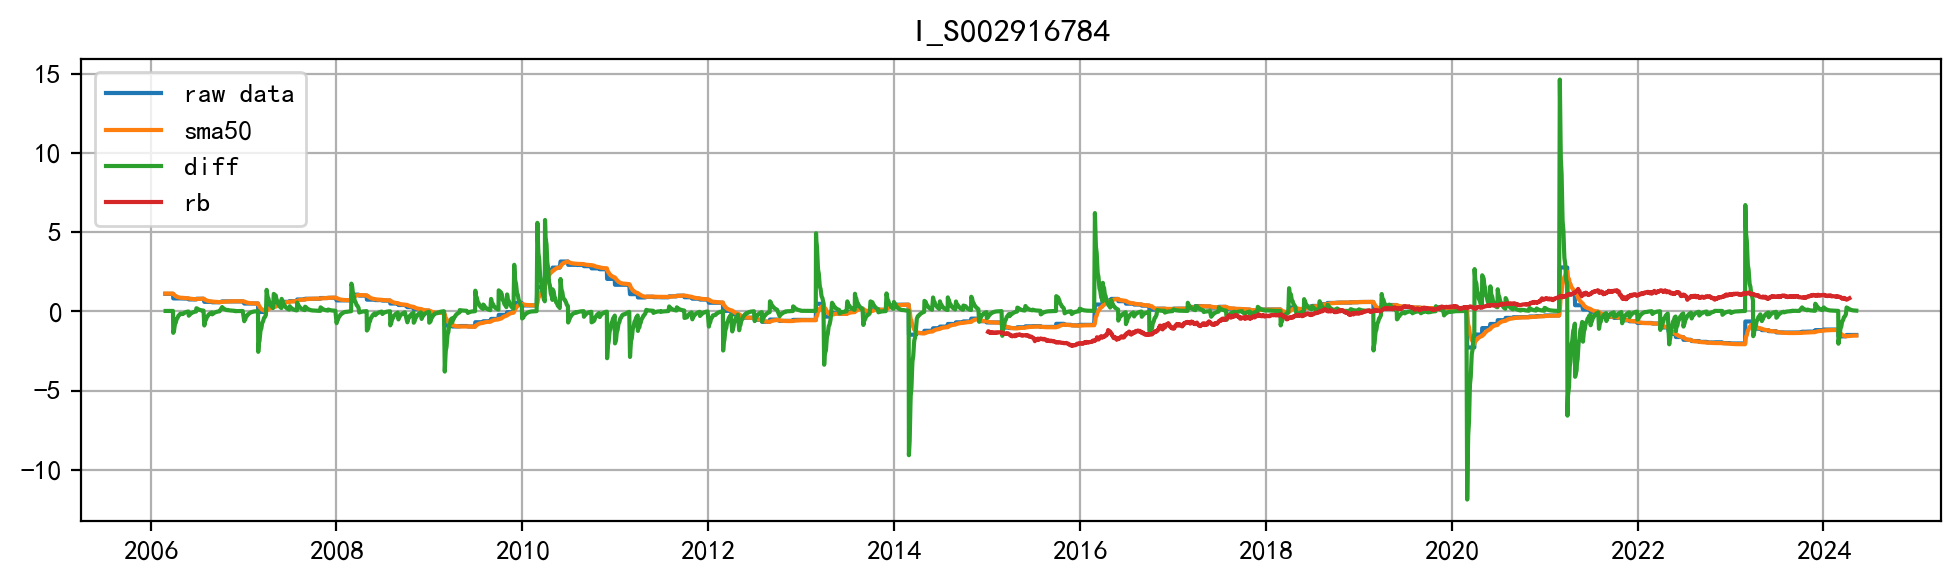

In [8]:
name = "I_S002916784"
I_S002916784 = pd.read_csv(f'{factor_dir}/real_estate.csv',index_col=0, parse_dates=True)[name]
I_S002916784 = I_S002916784.loc[:end_date]
plt.plot(utils.scale(I_S002916784), label='raw data')
I_S002916784 = utils.ema(I_S002916784, 1/10)
plt.plot(utils.scale(I_S002916784), label='sma50')
I_S002916784 = I_S002916784.diff()
plt.plot(utils.scale(I_S002916784, how='standard'), label='diff')
plt.plot(utils.scale(prices['rb'], how='standard'), label='rb')
plt.legend()
plt.title(name)

In [9]:
def test_params(name, end_date, ema_alpha=1/40):
    factor = pd.read_csv(f'{factor_dir}/real_estate.csv',index_col=0, parse_dates=True)[name]
    factor = factor.loc[:pd.to_datetime(end_date)]
    factor = utils.ema(factor, ema_alpha)
    factor = factor.diff()
    posi = factor / factor.abs()
    posi = posi.replace(np.nan, 0)
    price, posi = prices['rb'].align(posi, join='inner')
    price.name = posi.name = 'rb'
    nwm = strat_test.NetWorthMaker(price, posi)
    return nwm, posi

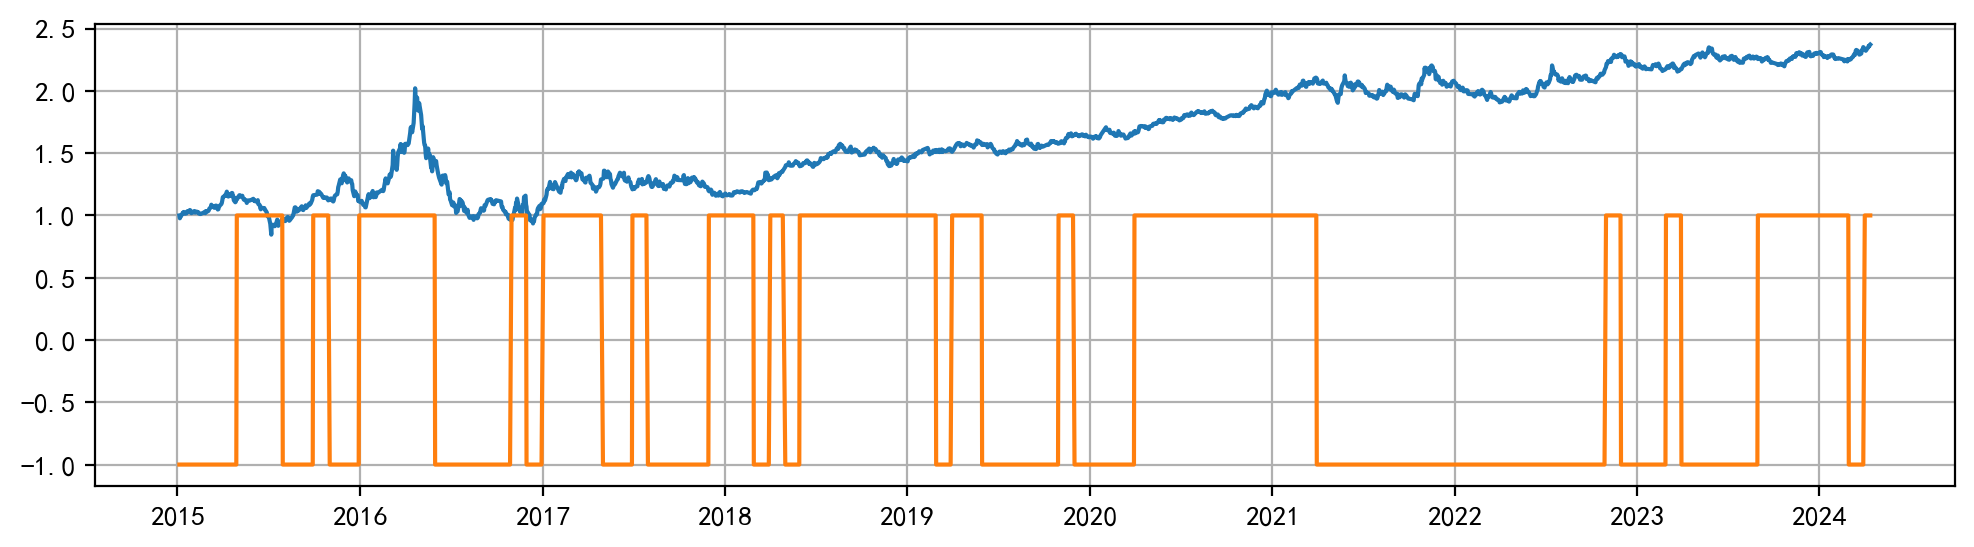

In [10]:
nwm, posi_2 = test_params(name, end_date, ema_alpha=1/10)
plt.plot(nwm.get_networth(), label='networth')
plt.plot(utils.scale(posi_2, how='1stvalue'), label='posi')
# plt.plot(utils.scale(opens['rb'], how='standard'), label='rb')


## I_S004543083
全国城市二手房出售挂牌价指数:当周值

Text(0.5, 1.0, 'I_S004543083')

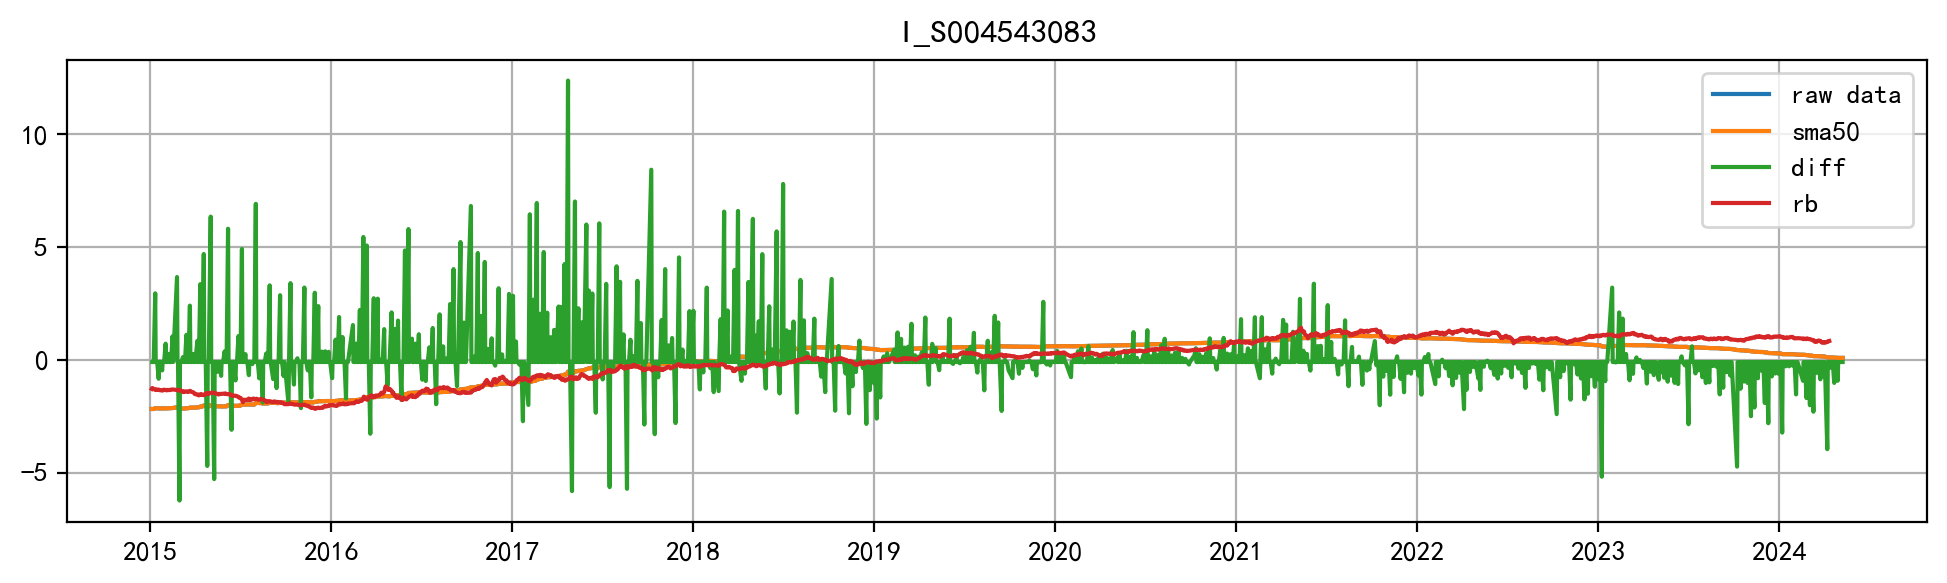

In [11]:
name = "I_S004543083"
I_S004543083 = pd.read_csv(f'{factor_dir}/real_estate.csv',index_col=0, parse_dates=True)[name]
I_S004543083 = I_S004543083.loc[:end_date]
plt.plot(utils.scale(I_S004543083), label='raw data')
I_S004543083 = utils.ema(I_S004543083, 1/1)
plt.plot(utils.scale(I_S004543083), label='sma50')
I_S004543083 = I_S004543083.diff()
plt.plot(utils.scale(I_S004543083, how='standard'), label='diff')
plt.plot(utils.scale(prices['rb'], how='standard'), label='rb')
plt.legend()
plt.title(name)

In [12]:
def test_params(name, end_date, ema_alpha=1/10):
    factor = pd.read_csv(f'{factor_dir}/real_estate.csv',index_col=0, parse_dates=True)[name]
    factor = factor.loc[:pd.to_datetime(end_date)]
    factor = utils.ema(factor, ema_alpha)
    factor = factor.diff()
    # for i, v in enumerate(factor):
    #     if v == 0:
    #         factor[i] = factor[i-1]
    posi = factor / factor.abs()
    posi = posi.replace(np.nan, 0)
    price, posi = prices['rb'].align(posi, join='inner')
    price.name = posi.name = 'rb'
    nwm = strat_test.NetWorthMaker(price, posi)
    return nwm, posi

In [150]:
alphas = range(1, 10)
rets = pd.DataFrame(index=[0], columns=alphas)

for alpha in tqdm(alphas):
    nwm, _ = test_params(name, end_date, ema_alpha=1/alpha)
    rets.loc[0, alpha] = nwm.get_total().loc['calmar']

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest\strat_test\calcfuncs.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return calc_return(nworth) / calc_max_drawdown(nworth)
C:\Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest\strat_test\calcfuncs.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return calc_return(nworth) / calc_std(nworth)
C:\Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest\strat_test\calcfuncs.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return calc_return(nworth) / calc_max_drawdown(nworth)
C:\Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest\strat_test\calcfuncs.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return calc_return(nworth) / calc_std(nworth)
C:\Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest\strat_test\calcfuncs.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return calc_return(nworth) / calc_max_drawdown(nworth

In [151]:
rets

,1,2,3,4,5,6,7,8,9
0,0.12,4.31,1.44,1.19,0.8,0.9,0.6,0.67,0.31


<Axes: >

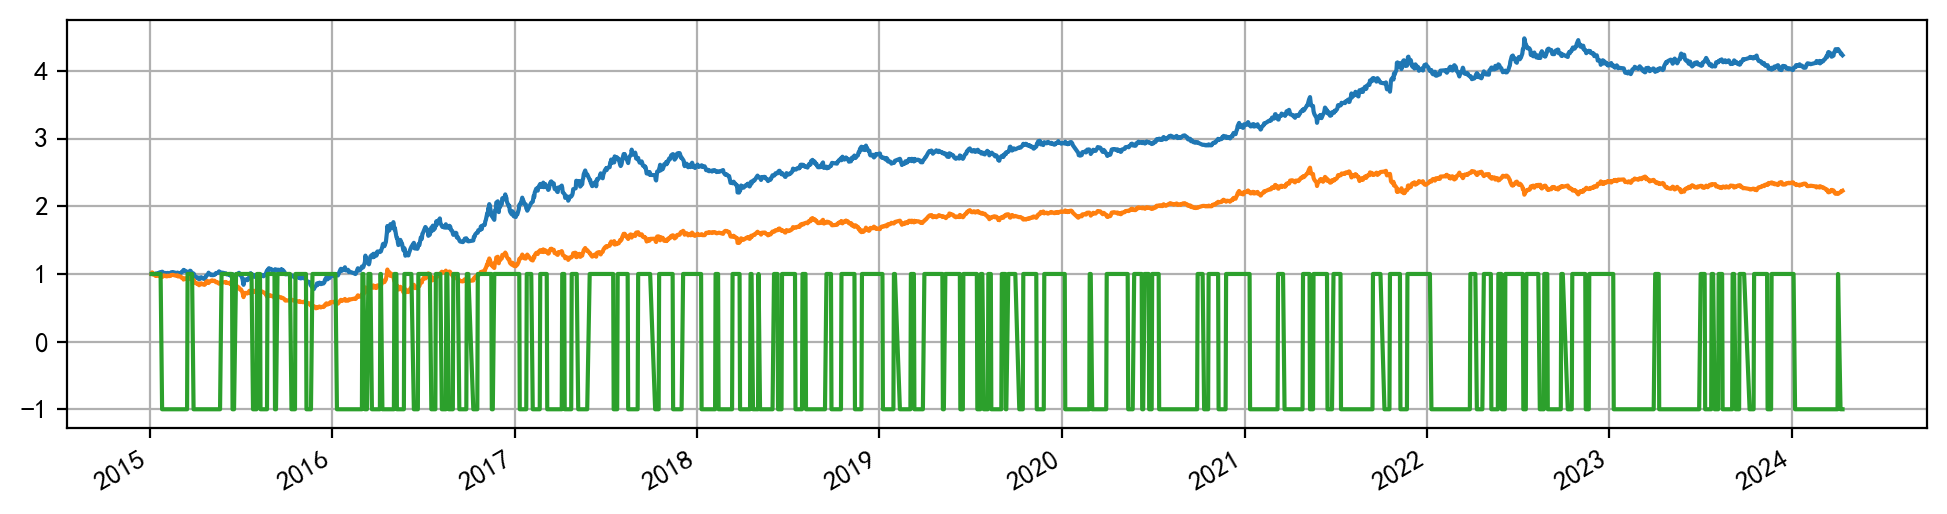

In [13]:
nwm, posi_3 = test_params(name, end_date, ema_alpha=1/4)
plt.plot(nwm.get_networth(), label='networth')
plt.plot(utils.scale(prices['rb'], "1stvalue"))
posi.plot()

## I_M001620724
房地产开发投资:累计同比

Text(0.5, 1.0, 'I_M001620724')

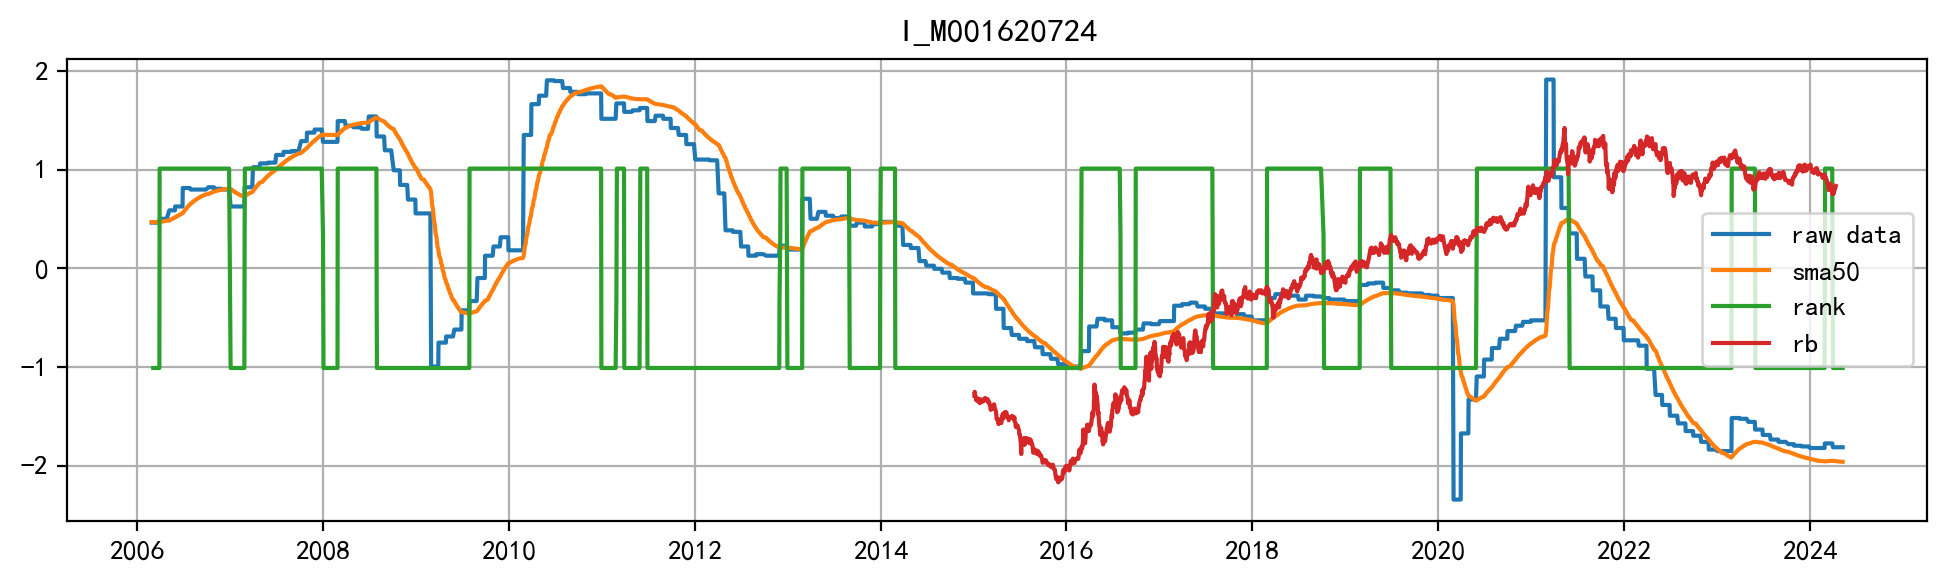

In [14]:
name = "I_M001620724"
I_M001620724 = pd.read_csv(f'{factor_dir}/real_estate.csv',index_col=0, parse_dates=True)[name]
I_M001620724 = I_M001620724.loc[:end_date]
plt.plot(utils.scale(I_M001620724), label='raw data')
I_M001620724 = utils.ema(I_M001620724, 1/55)
plt.plot(utils.scale(I_M001620724), label='sma50')
I_M001620724 = utils.ts_rank(I_M001620724, 4, "dynamic") - 0.5
plt.plot(utils.scale(I_M001620724, how='divstd'), label='rank')
plt.plot(utils.scale(prices['rb'], how='standard'), label='rb')
plt.legend()
plt.title(name)

In [15]:
def test_params(name, end_date, ema_alpha, ts_rank_w):
    factor = pd.read_csv(f'{factor_dir}/real_estate.csv',index_col=0, parse_dates=True)[name]
    factor = factor.loc[:pd.to_datetime(end_date)]
    factor = utils.ema(factor, ema_alpha)
    factor = utils.ts_rank(factor, ts_rank_w, "dynamic") - 0.5
    posi = factor / factor.abs()
    posi = posi.replace(np.nan, 0)
    price, posi = prices['rb'].align(posi, join='inner')
    price.name = posi.name = 'rb'
    nwm = strat_test.NetWorthMaker(price, posi)
    return nwm, posi

In [16]:
alphas = range(5, 101, 5)
ws = range(2, 10, 1)
rets = pd.DataFrame(index=alphas, columns=ws)

for alpha in tqdm(alphas):
    for w in ws:
        nwm, _ = test_params(name, end_date, ema_alpha=1/alpha, ts_rank_w=w)
        rets.loc[alpha, w] = nwm.get_total().loc['calmar']

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [181]:
rets.apply(pd.to_numeric).style.background_gradient(axis=None).format("{:.2f}")

,2,3,4,5,6,7,8,9
5,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04
10,0.04,0.04,0.05,0.05,0.04,0.05,0.07,0.10
15,0.40,0.42,0.44,0.43,0.41,0.43,0.45,0.43
20,0.39,0.40,0.40,0.44,0.48,0.49,0.50,0.45
25,0.34,0.37,0.39,0.38,0.37,0.37,0.36,0.34
30,0.36,0.38,0.40,0.42,0.43,0.40,0.36,0.30
35,0.53,0.53,0.54,0.56,0.59,0.60,0.60,0.52
40,0.79,0.79,0.78,0.82,0.85,0.80,0.75,0.70
45,0.76,0.79,0.81,0.76,0.71,0.71,0.70,0.72
50,1.08,1.12,1.16,1.10,1.03,1.01,0.99,0.97


<Axes: >

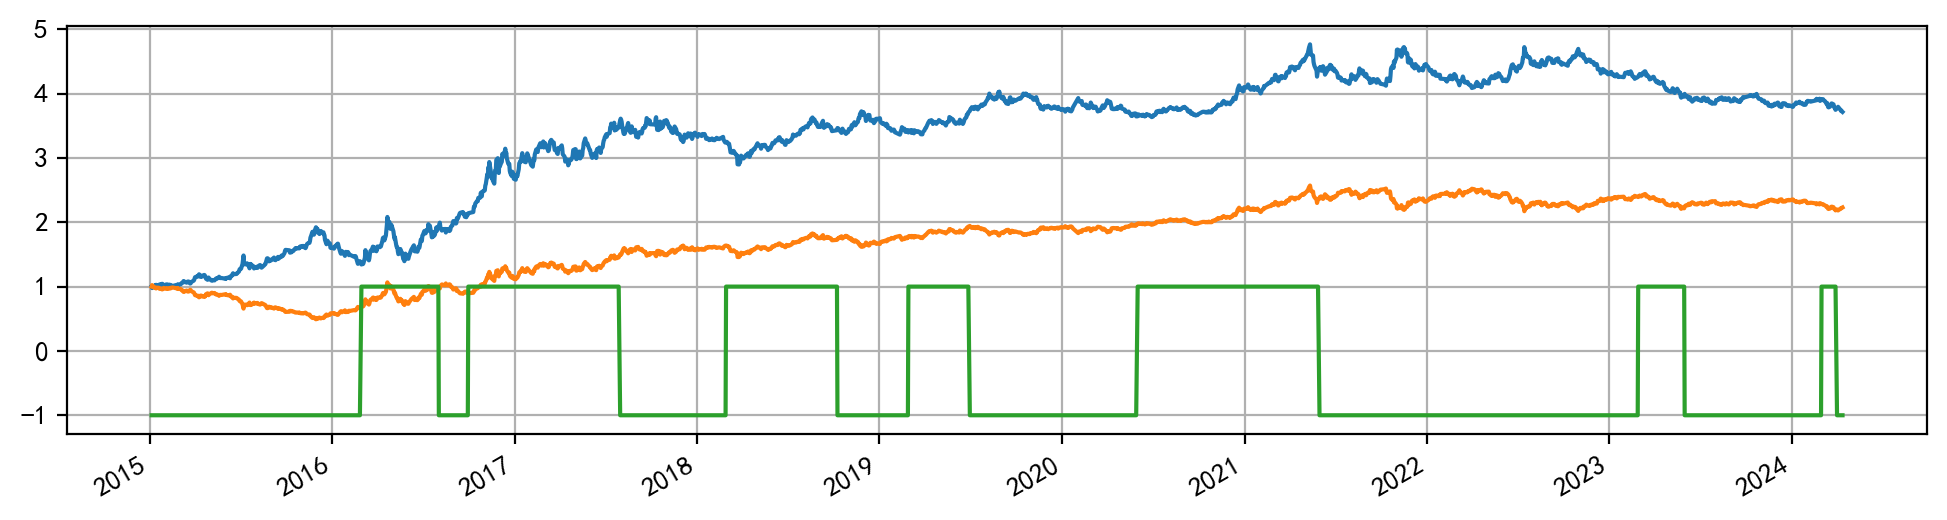

In [17]:
nwm, posi_4 = test_params(name, end_date, ema_alpha=1/55, ts_rank_w=4)
plt.plot(nwm.get_networth(), label='networth')
plt.plot(utils.scale(prices['rb'], "1stvalue"))
posi_4.plot()

## I_M002807944
房地产开发投资:当月同比

Text(0.5, 1.0, 'I_M002807944')

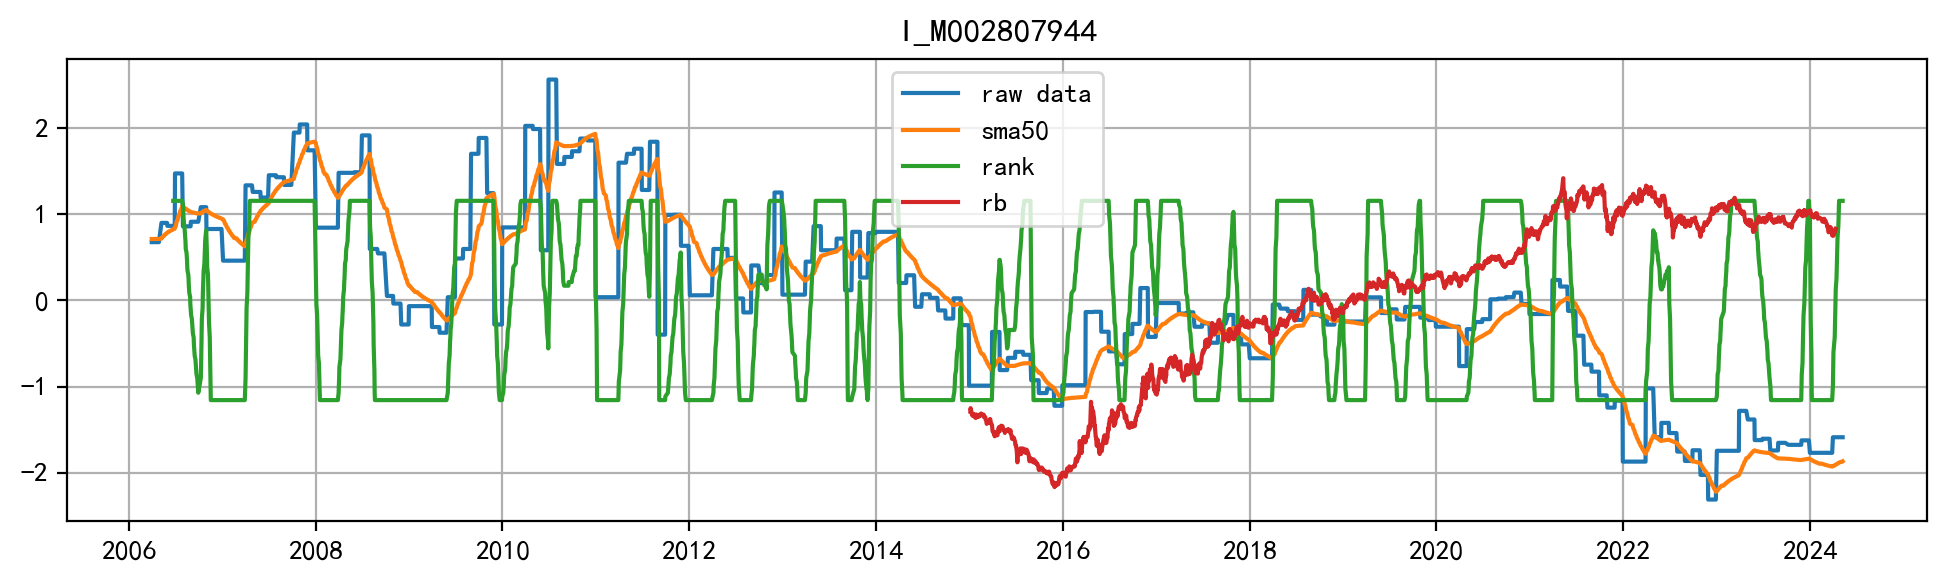

In [18]:
name = "I_M002807944"
I_M002807944 = pd.read_csv(f'{factor_dir}/real_estate.csv',index_col=0, parse_dates=True)[name]
I_M002807944 = I_M002807944.loc[:end_date]
plt.plot(utils.scale(I_M002807944), label='raw data')
I_M002807944 = utils.ema(I_M002807944, 1/50)
plt.plot(utils.scale(I_M002807944), label='sma50')
I_M002807944 = utils.ts_rank(I_M002807944, 55, "dynamic") - 0.5
plt.plot(utils.scale(I_M002807944, how='divstd'), label='rank')
plt.plot(utils.scale(prices['rb'], how='standard'), label='rb')
plt.legend()
plt.title(name)

In [19]:
def test_params(name, end_date, ema_alpha, ts_rank_w):
    factor = pd.read_csv(f'{factor_dir}/real_estate.csv',index_col=0, parse_dates=True)[name]
    factor = factor.loc[:pd.to_datetime(end_date)]
    factor = utils.ema(factor, ema_alpha)
    factor = utils.ts_rank(factor, ts_rank_w, "dynamic") - 0.5
    posi = factor / factor.abs()
    posi = posi.replace(np.nan, 0)
    price, posi = prices['rb'].align(posi, join='inner')
    price.name = posi.name = 'rb'
    nwm = strat_test.NetWorthMaker(price, posi)
    return nwm, posi

In [189]:
alphas = range(5, 101, 5)
ws = range(5, 201, 5)
rets = pd.DataFrame(index=alphas, columns=ws)

for alpha in tqdm(alphas):
    for w in ws:
        nwm, _ = test_params(name, end_date, ema_alpha=1/alpha, ts_rank_w=w)
        rets.loc[alpha, w] = nwm.get_total().loc['calmar']

  0%|          | 0/20 [00:00<?, ?it/s]

In [190]:
rets.apply(pd.to_numeric).style.background_gradient(axis=None).format("{:.2f}")

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200
5,-0.09,-0.09,-0.09,-0.08,-0.08,-0.08,-0.07,-0.05,-0.08,-0.07,-0.00,0.06,0.02,0.17,0.14,0.25,0.45,0.55,0.47,0.98,1.02,1.22,1.50,1.36,1.52,1.25,1.64,1.01,0.73,0.38,0.56,0.51,0.62,0.62,0.91,0.54,0.71,0.63,0.86,0.90
10,-0.09,-0.08,-0.09,-0.07,-0.07,-0.08,-0.06,-0.02,0.17,0.29,0.52,0.31,0.18,0.09,0.11,0.10,0.25,0.67,0.79,0.69,0.95,0.69,0.79,0.79,0.76,0.72,0.47,0.61,0.49,0.82,0.63,0.39,0.42,0.30,0.46,0.49,0.32,0.29,0.39,0.24
15,0.15,0.18,0.14,0.07,0.16,0.33,0.56,0.72,0.34,0.27,0.33,0.22,0.23,0.56,0.32,0.41,0.64,0.72,0.60,0.42,0.43,0.67,0.68,0.50,0.34,0.33,0.44,0.58,0.54,0.26,0.37,0.49,0.38,0.35,0.24,0.27,0.50,0.72,0.18,0.15
20,0.10,0.12,0.13,0.35,0.43,0.47,0.44,0.31,0.35,0.44,0.32,0.40,0.52,0.46,0.63,0.92,0.86,0.70,0.61,0.56,0.38,0.21,0.29,0.18,0.29,0.19,0.06,0.11,0.12,0.24,0.25,0.10,0.06,0.05,0.21,0.39,0.25,0.10,0.07,0.06
25,0.03,0.02,0.14,0.32,0.27,0.31,0.42,0.47,0.59,0.45,0.65,0.66,0.54,0.62,0.62,0.91,0.81,0.60,0.63,0.27,0.30,0.24,0.10,0.20,0.11,0.12,0.16,0.20,0.14,0.10,0.09,0.10,0.06,0.10,0.10,0.07,0.02,0.02,0.01,0.00
30,0.02,0.10,0.24,0.33,0.33,0.48,0.62,0.40,0.64,1.07,0.70,0.51,0.72,0.70,0.85,0.77,0.59,0.42,0.32,0.25,0.20,0.14,0.24,0.10,0.16,0.21,0.15,0.10,0.08,0.04,0.10,0.14,0.00,-0.02,-0.02,-0.01,-0.01,0.00,-0.01,-0.01
35,0.50,0.43,0.59,1.00,1.08,0.96,0.75,0.80,0.96,0.87,0.86,0.75,0.84,0.91,0.78,0.45,0.36,0.38,0.40,0.23,0.24,0.22,0.16,0.29,0.25,0.11,0.11,0.13,0.07,0.01,-0.00,-0.03,-0.03,-0.03,-0.03,-0.05,-0.01,0.00,-0.01,-0.01
40,0.44,0.50,0.62,1.10,1.18,1.09,0.62,0.87,0.90,1.04,1.22,0.92,1.09,0.59,0.55,0.29,0.40,0.53,0.27,0.45,0.18,0.25,0.24,0.22,0.23,0.23,0.05,-0.01,-0.03,-0.03,-0.04,-0.05,-0.04,-0.03,-0.03,-0.03,-0.04,-0.04,-0.03,-0.01
45,0.63,0.59,1.02,1.28,1.18,0.64,0.97,0.90,1.61,1.92,1.77,1.98,0.69,0.90,0.38,0.55,0.63,0.55,0.55,0.17,0.46,0.59,0.38,0.08,0.08,0.05,0.03,-0.03,-0.05,-0.02,-0.04,-0.05,-0.06,-0.06,-0.05,-0.04,-0.02,-0.02,-0.02,-0.02
50,0.60,0.78,1.01,1.28,1.12,0.99,1.06,1.22,2.03,1.45,2.09,2.91,1.61,0.52,0.79,0.95,0.86,1.08,0.38,0.38,0.36,0.25,0.13,0.09,0.03,0.02,-0.00,-0.06,-0.05,-0.06,-0.05,-0.05,-0.05,-0.05,-0.03,-0.04,-0.00,-0.01,-0.00,0.00


<Axes: >

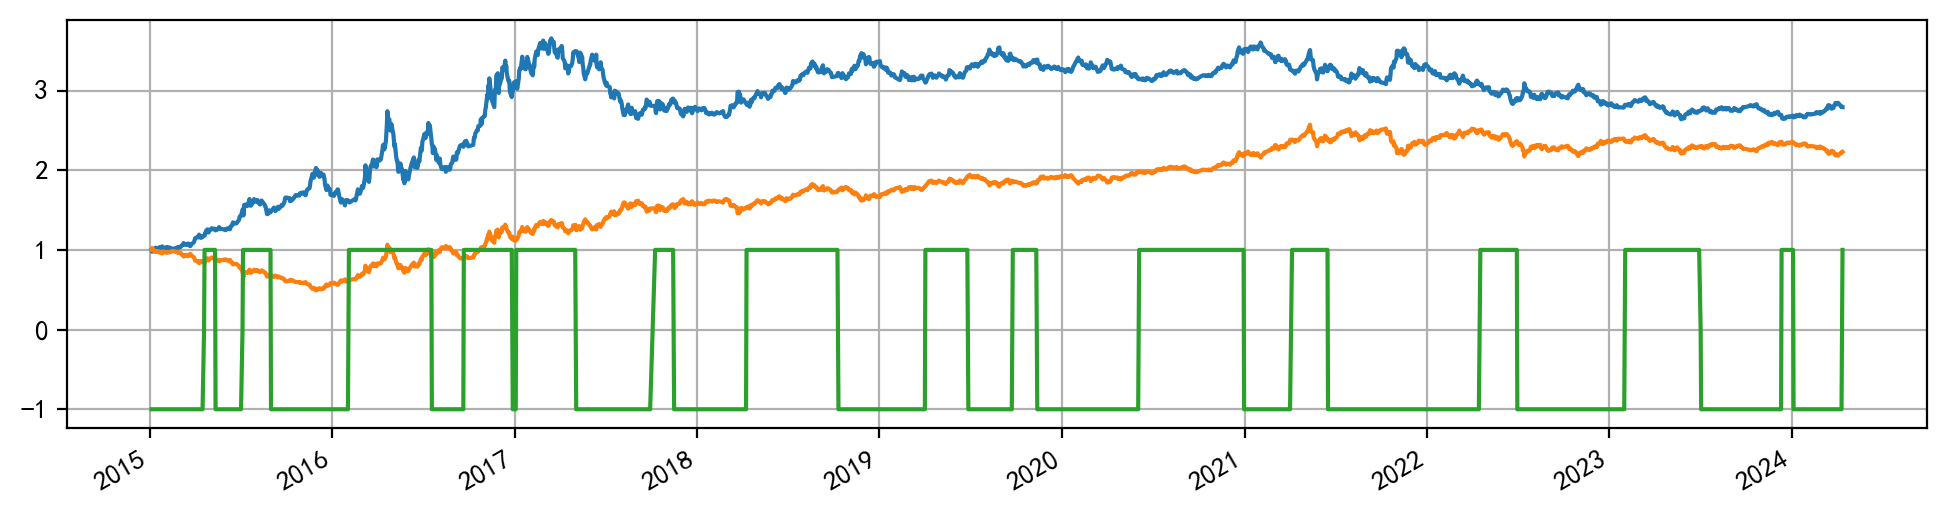

In [20]:
nwm, posi_5 = test_params(name, end_date, ema_alpha=1/50, ts_rank_w=55)
plt.plot(nwm.get_networth(), label='networth')
plt.plot(utils.scale(prices['rb'], "1stvalue"))
posi_5.plot()

## 需求合成并检验可用性
I_S006273513、I_S004543083、I_M001620724

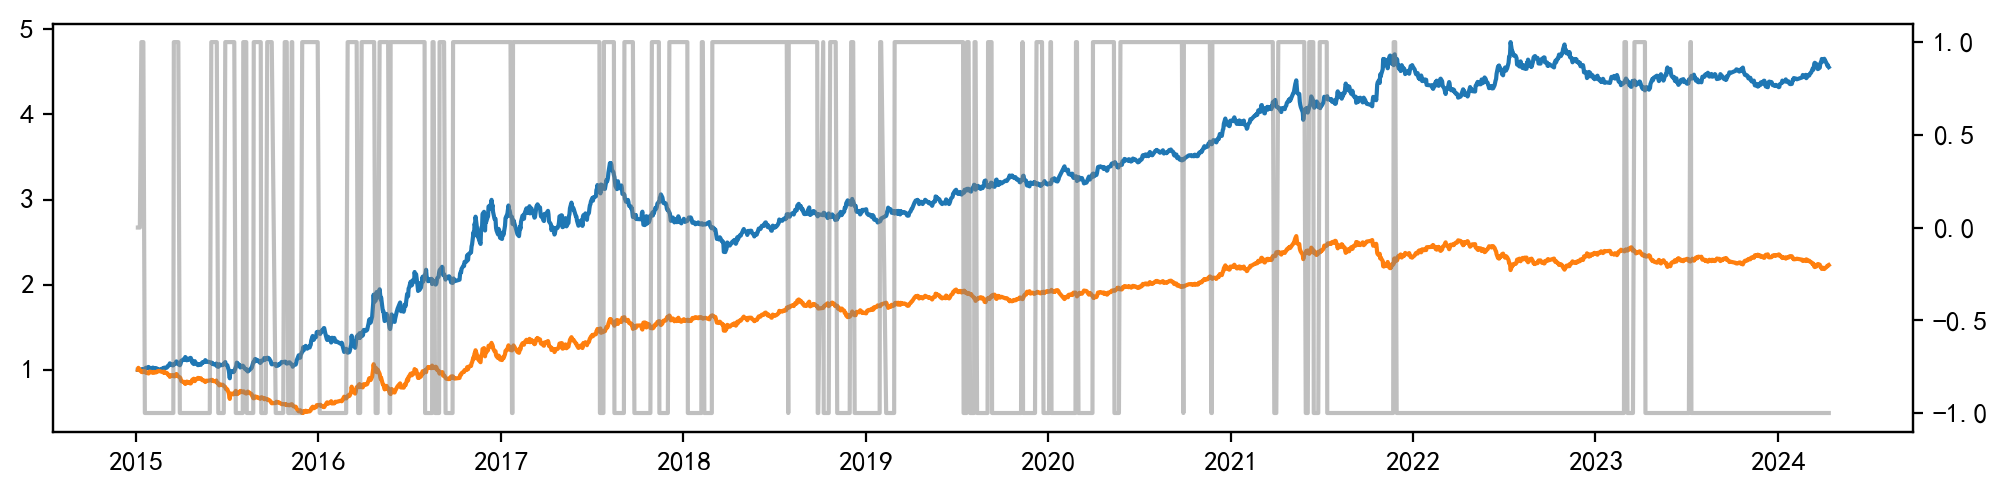

In [21]:
posi_comb = posi_1 + posi_3 + posi_4
posi_comb = posi_comb / posi_comb.abs()
posi_comb = posi_comb.replace(np.nan, 0)
price, posi_comb = prices['rb'].align(posi_comb, join='inner')
price.name = posi_comb.name = 'rb'
nwm = strat_test.NetWorthMaker(price, posi_comb)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

posi_comb.plot(ax=ax2, color='gray', alpha=0.5, label='posi')
ax1.plot(nwm.get_networth(), label='networth')
ax1.plot(utils.scale(prices['rb'], "1stvalue"))

ax1.grid()
ax2.grid()

In [22]:
nwm.get_annual()

,days,acc.%,ret.%,std.%,mdd.%,calmar,sharpe,tr.%,long.%,short.%,abs.%
2015,244,54.10,44.71,25.27,21.71,2.06,1.77,7.58,37.30,60.66,97.95
2016,244,54.51,77.46,41.56,24.00,3.23,1.86,5.33,69.67,30.33,100.00
2017,244,50.41,7.89,24.24,21.25,0.37,0.33,4.10,77.05,22.95,100.00
2018,243,51.03,3.66,13.25,14.57,0.25,0.28,5.35,69.55,30.45,100.00
2019,244,50.41,10.05,10.12,5.39,1.86,0.99,5.74,49.18,50.82,100.00
2020,243,56.38,23.22,9.15,5.92,3.92,2.54,4.53,74.07,25.93,100.00
2021,243,51.03,16.33,13.80,10.53,1.55,1.18,3.70,46.09,53.91,100.00
2022,242,46.69,-2.50,11.27,8.98,-0.28,-0.22,0.00,0.00,100.00,100.00
2023,242,48.35,-2.02,7.53,5.11,-0.39,-0.27,2.48,8.68,91.32,100.00
2024,66,59.09,5.36,3.69,2.12,2.53,1.45,0.00,0.00,100.00,100.00


用公司回测系统回测

In [272]:
utils.few2crossing(posi_comb).to_csv('data/position/rb_demand.csv')

In [275]:
!python backtest.py "rb_d" "C:\Users\ifwha\OneDrive - CUHK-Shenzhen\桌面\工作\A06_策略研究\黑色板块策略\data\position\rb_demand.csv"

保存多头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\rb_d\rb_d_多头.csv
保存空头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\rb_d\rb_d_空头.csv
保存全部持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\rb_d\rb_d.csv
读取持仓文件生成净值: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\rb_d\rb_d.csv
Figure(1200x800)
年化收益率 年化波动率 夏普率 最大回撤  最长回撤期 年换手率
   18.436%    13.905% 1.3259 -23.329%         724 1466.44%


In [23]:
net_worth = pd.read_csv('result/rb_d/历史净值.csv', index_col=0, parse_dates=True)
net_worth, posi_comb = net_worth.align(posi_comb, join='inner', axis=0)
sp = strat_test.StratPerf(net_worth, posi_comb)
sp.get_all()
# sp.plot()

,days,acc.%,ret.%,std.%,mdd.%,calmar,sharpe,tr.%,long.%,short.%,abs.%
2015,237,54.01,26.04,17.44,10.77,2.42,1.49,7.59,37.55,62.45,100.0
2016,244,53.69,45.87,25.22,14.60,3.14,1.82,5.33,69.67,30.33,100.0
2017,244,51.23,8.91,16.32,14.49,0.62,0.55,4.10,77.05,22.95,100.0
2018,243,50.62,-2.94,11.58,12.46,-0.24,-0.25,5.35,69.55,30.45,100.0
2019,244,49.18,5.55,9.36,4.82,1.15,0.59,5.74,49.18,50.82,100.0
2020,243,55.56,19.79,8.16,4.34,4.56,2.43,4.53,74.07,25.93,100.0
2021,243,51.03,10.24,12.49,9.91,1.03,0.82,3.70,46.09,53.91,100.0
2022,242,46.69,-1.42,9.87,7.24,-0.20,-0.14,0.00,0.00,100.00,100.0
2023,242,47.52,-2.21,6.56,4.62,-0.48,-0.34,2.48,8.68,91.32,100.0
2024,66,59.09,4.63,3.08,1.72,2.69,1.50,0.00,0.00,100.00,100.0


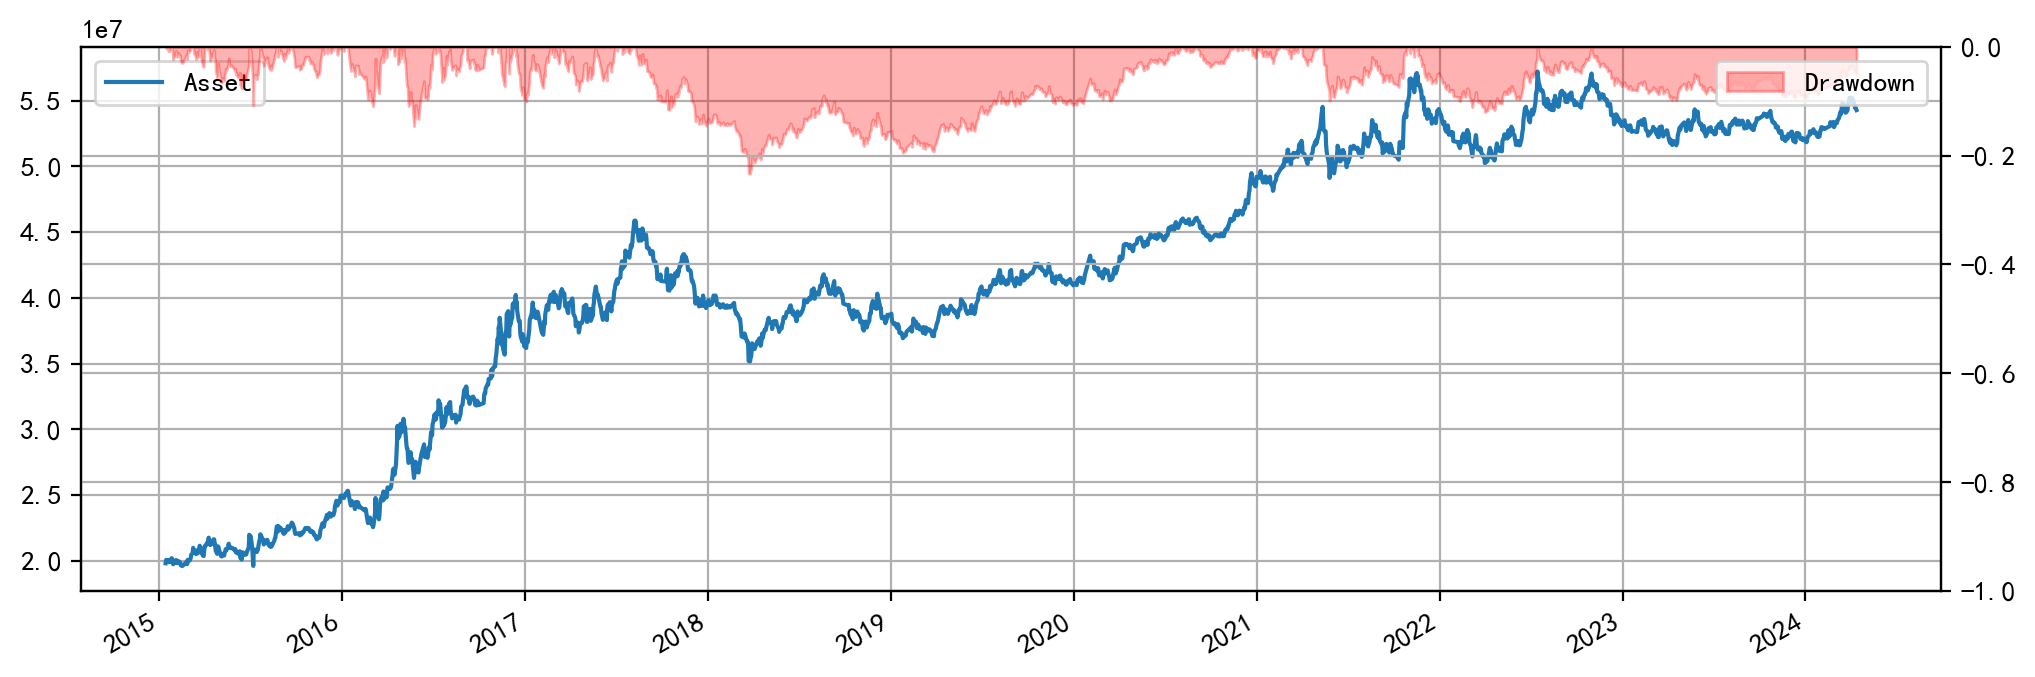

In [24]:
sp.plot()

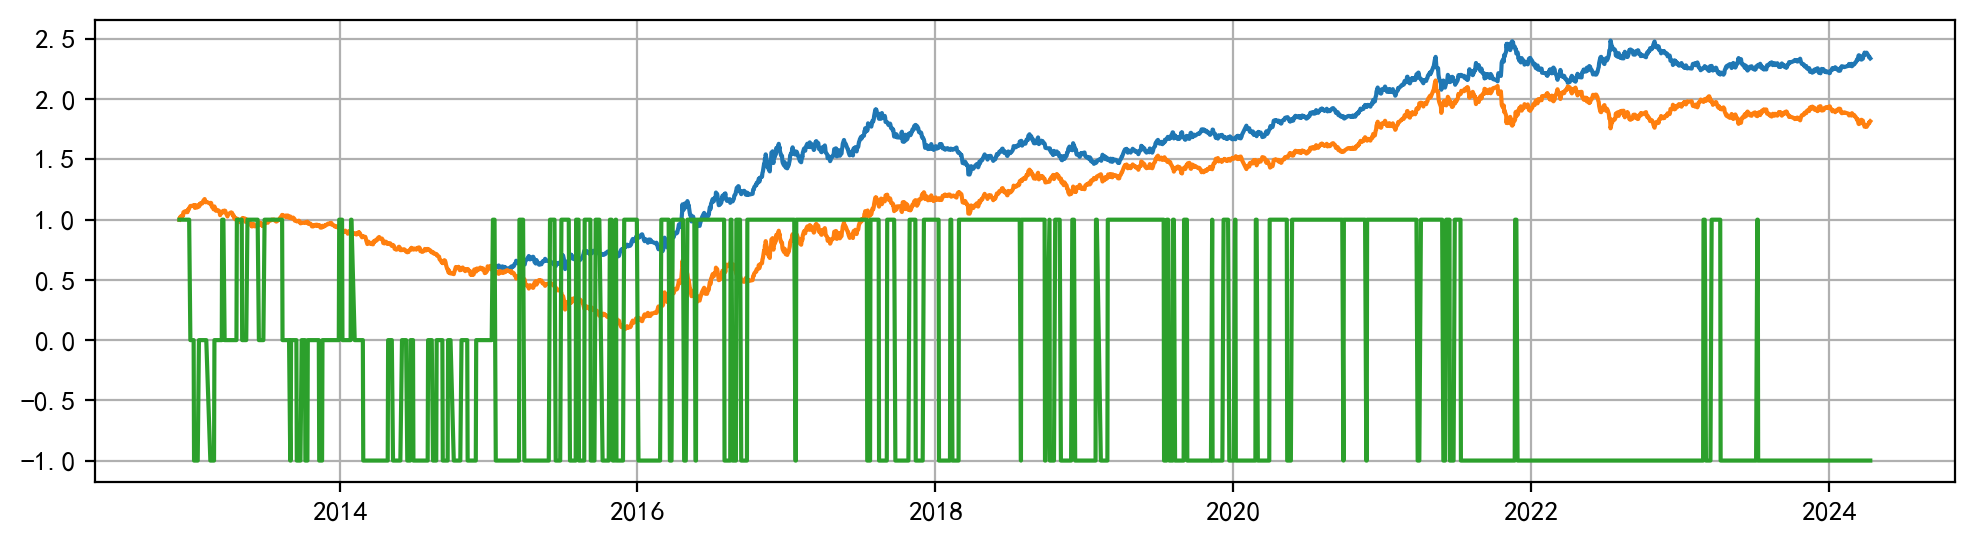

In [287]:
plt.plot(utils.scale(net_worth, "1stvalue")-0.4, label='networth')
plt.plot(utils.scale(prices['rb'], "1stvalue"), label='rb')
plt.plot(utils.scale(posi_comb, how='1stvalue'), label='posi')